# Legendre Memory Units in Nengo

Legendre Memory Units (LMUs) are
a novel recurrent neural network architecture, described in
[Voelker, Kajić, and Eliasmith (NeurIPS 2019)][paper].
We will not go into much of the underlying details of these methods here;
broadly speaking, we can think of an LMU as a recurrent network
that does a very good job of representing
the temporal information in some input signal.
Since most RNN tasks involve computing
some function of that temporal information,
the better the RNN is at representing the temporal information
the better it will be able to perform the task.
See the [paper][] for all the details!

In this example we will show how an LMU can be used
to delay an input signal for some fixed length of time.
This is a simple sounding task, but performing an accurate delay
requires the network to store the complete history of the input signal
across the delay period.
So it is a good measure of a network's fundamental temporal storage.

[paper]: https://papers.nips.cc/paper/9689-legendre-memory-units-continuous-time-representation-in-recurrent-neural-networks.pdf

In [1]:
%matplotlib inline

from collections import deque

import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.utils.filter_design import cont2discrete

Our LMU in this example will have two parameters:
the length of the time window it is optimized to store,
and the number of Legendre polynomials used to represent the signal
(using higher order polynomials
allows the LMU to represent higher frequency information).

The input will be a band-limited white noise signal,
which has its own parameters 
determining the amplitude and frequency of the signal.

Feel free to adjust any of these parameters
to see what impact they have on the model's performance.

In [2]:
# parameters of LMU
theta = 1.0  # length of window (in seconds)
order = 8  # number of Legendre polynomials representing window

# parameters of input signal
freq = 2  # frequency limit
rms = 0.30  # amplitude of input (set to keep within [-1, 1])
delay = 0.5  # length of time delay network will learn

# simulation parameters
dt = 0.001  # simulation timestep
sim_t = 100  # length of simulation
seed = 0  # fixed for deterministic results

Next we need to compute
the analytically derived weight matrices used in the LMU.
These are determined statically based on
the `theta`/`order` parameters from above.
It is also possible to optimize these parameters using backpropagation,
using a framework such as [Nengo DL](https://www.nengo.ai/nengo-dl).

In [3]:
# compute the A and B matrices according to the LMU's mathematical derivation
# (see the paper for details)
Q = np.arange(order, dtype=np.float64)
R = (2 * Q + 1)[:, None] / theta
j, i = np.meshgrid(Q, Q)

A = np.where(i < j, -1, (-1.0) ** (i - j + 1)) * R
B = (-1.0) ** Q[:, None] * R
C = np.ones((1, order))
D = np.zeros((1,))

A, B, _, _, _ = cont2discrete((A, B, C, D), dt=dt, method="zoh")

Next we will set up an artificial synapse model
to compute an ideal delay
(we'll use this to train the model later on).
And we can run a simple network containing
just our input signal and the ideal delay to see what that looks like.

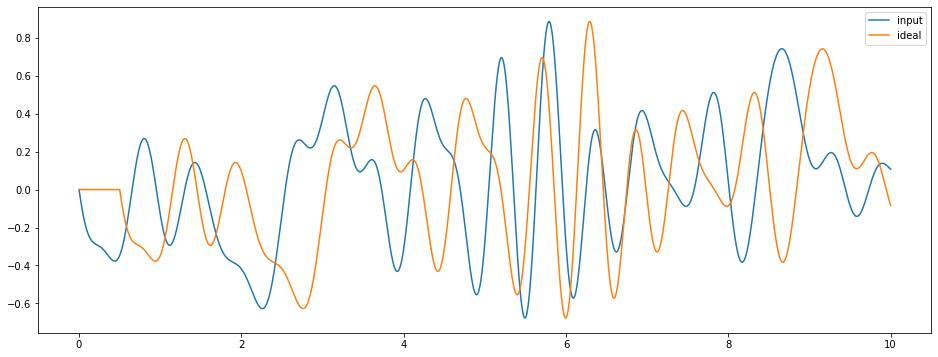

In [4]:
class IdealDelay(nengo.synapses.Synapse):
    def __init__(self, delay):
        super().__init__()
        self.delay = delay

    def make_state(self, *args, **kwargs):
        return {}

    def make_step(self, shape_in, shape_out, dt, rng, state):
        # buffer the input signal based on the delay length
        buffer = deque([0] * int(self.delay / dt))

        def delay_func(t, x):
            buffer.append(x.copy())
            return buffer.popleft()

        return delay_func

    
with nengo.Network(seed=seed) as net:
    # create the input signal
    stim = nengo.Node(
        output=nengo.processes.WhiteSignal(
            high=freq, period=sim_t, rms=rms, y0=0, seed=seed
        )
    )
    
    # probe input signal and an ideally delayed version of input signal
    p_stim = nengo.Probe(stim)
    p_ideal = nengo.Probe(stim, synapse=IdealDelay(delay))
    
# run the network and display results
with nengo.Simulator(net) as sim:
    sim.run(10)
    
    plt.figure(figsize=(16, 6))
    plt.plot(sim.trange(), sim.data[p_stim], label="input")
    plt.plot(sim.trange(), sim.data[p_ideal], label="ideal")
    plt.legend();

Now we are ready to build the LMU.
The full LMU architecture consists of two components:
a linear memory, and a nonlinear hidden state.
But the nonlinear hidden state is really only useful
when it is optimized using backpropagation (see
[this example in NengoDL](https://www.nengo.ai/nengo-dl/examples/lmu.html)).
So here we will just build the linear memory component.

In [5]:
with net:
    lmu = nengo.Node(size_in=order)
    nengo.Connection(stim, lmu, transform=B, synapse=None)
    nengo.Connection(lmu, lmu, transform=A, synapse=0)    

On its own the LMU isn't performing a task,
it is just internally representing the input signal.
So to get this network to perform a function,
we will add an output Ensemble
that gets the output of the LMU as input.
Then we will train the output weights of that Ensemble
using the PES online learning rule.
The error signal will be based on the ideally delayed input signal,
so the network should learn to compute that same delay.

In [6]:
with net:
    ens = nengo.Ensemble(1000, order, neuron_type=nengo.SpikingRectifiedLinear())
    nengo.Connection(lmu, ens, synapse=None)

    out = nengo.Node(size_in=1)

    # we'll use a Node to compute the error signal so that we can shut off
    # learning after a while (in order to assess the network's generalization)
    err_node = nengo.Node(lambda t, x: x if t < sim_t * 0.8 else 0, size_in=1)
    
    # the target signal is the ideally delayed version of the input signal,
    # which is subtracted from the ensemble's output in order to compute the
    # PES error
    nengo.Connection(stim, err_node, synapse=IdealDelay(delay), transform=-1)
    nengo.Connection(out, err_node, synapse=None)
    
    learn_conn = nengo.Connection(
        ens, out, function=lambda x: 0, learning_rule_type=nengo.PES(2e-4)
    )
    nengo.Connection(err_node, learn_conn.learning_rule, synapse=None)

    p_out = nengo.Probe(out)

Finally, we can run the full model
to see it learning to perform the delay task.

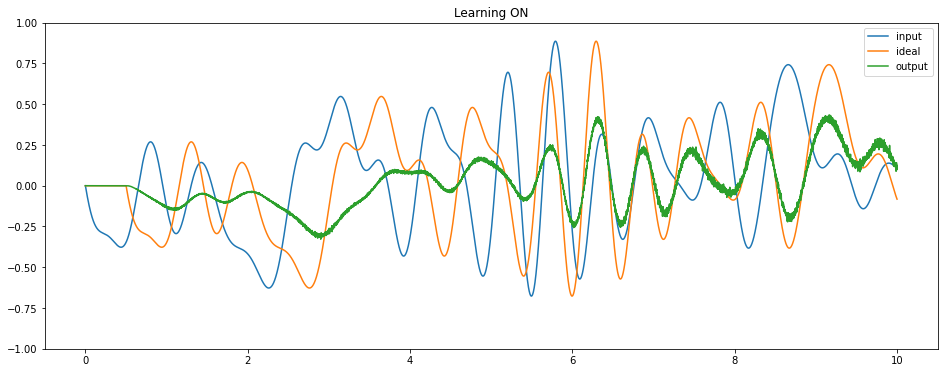

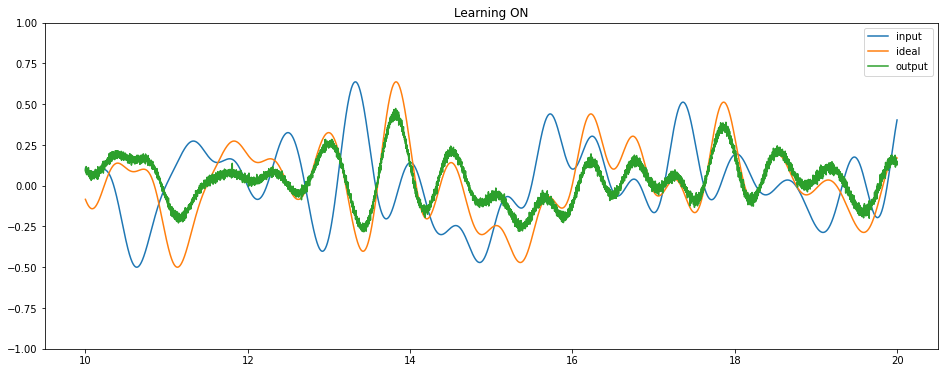

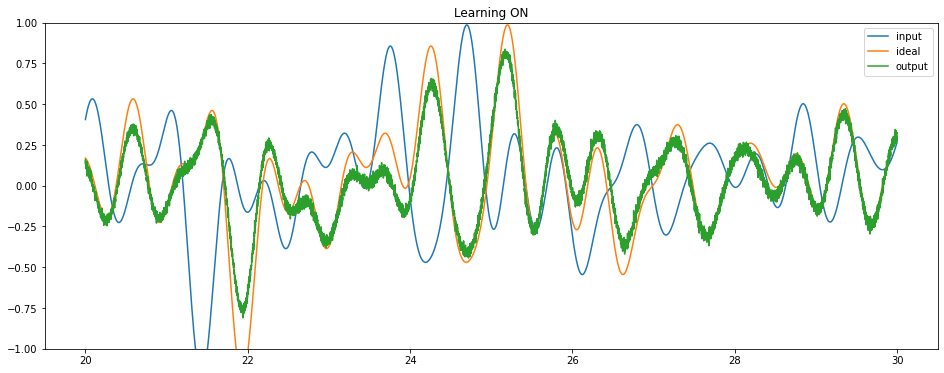

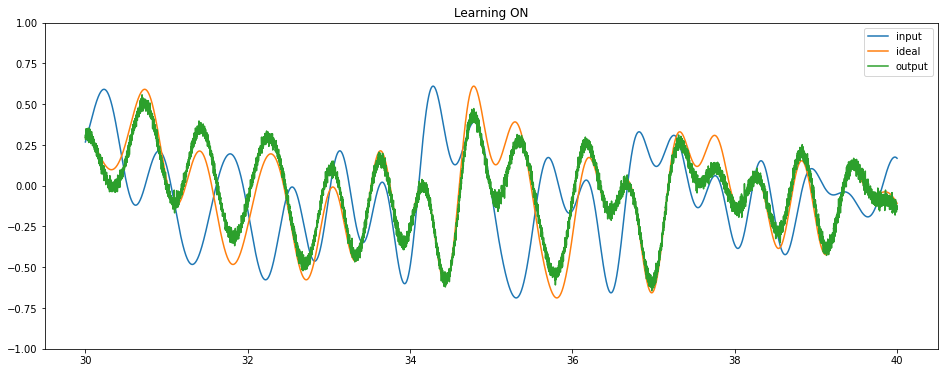

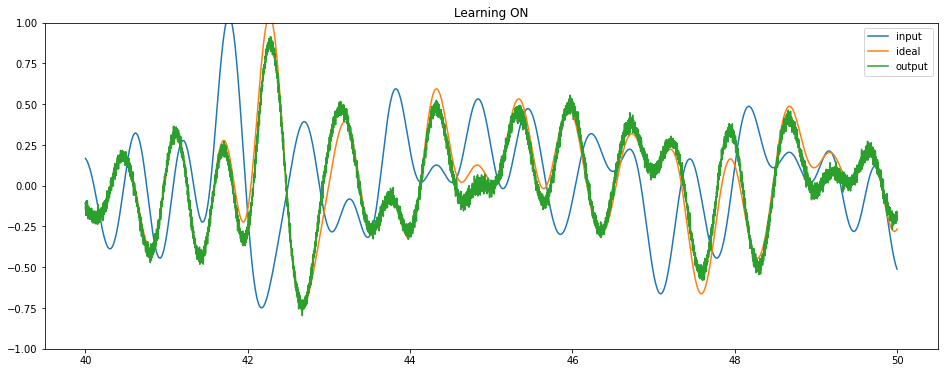

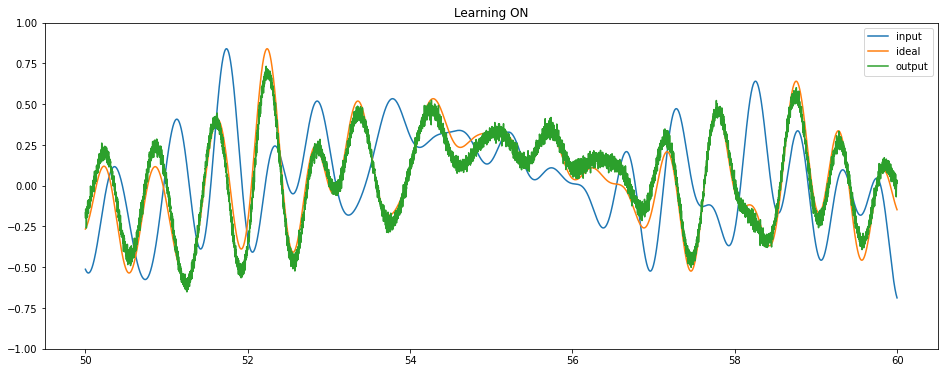

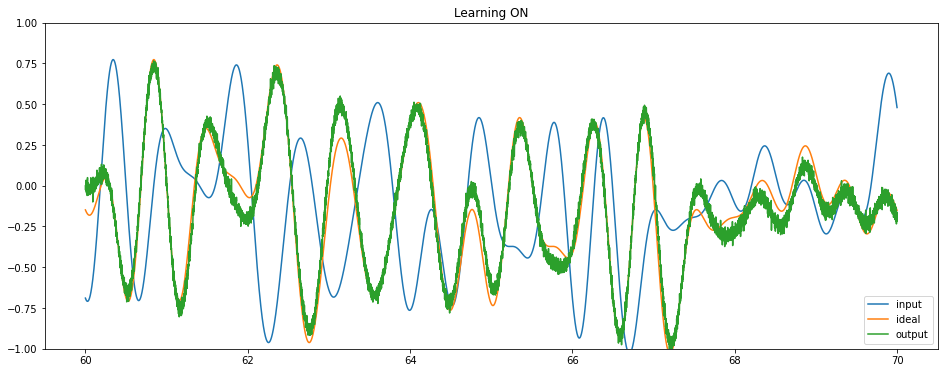

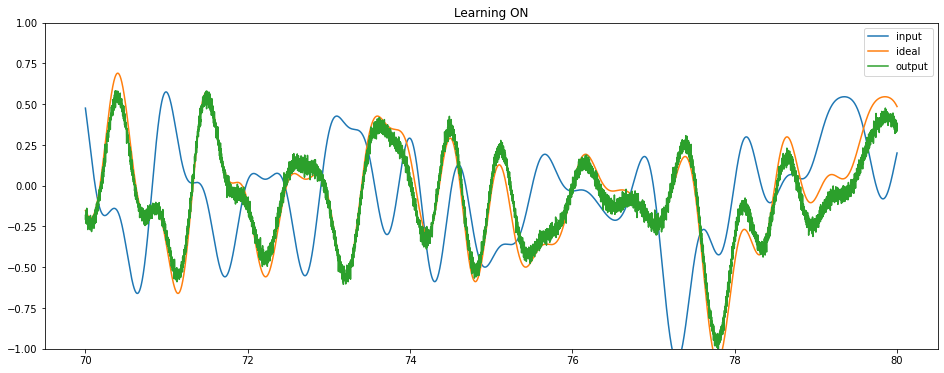

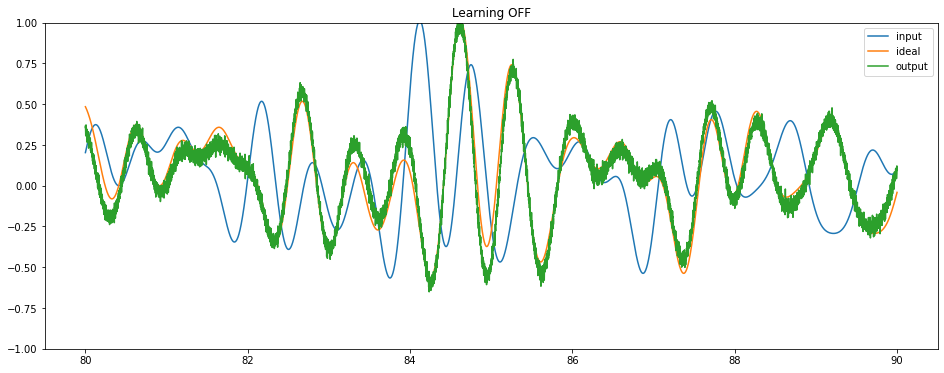

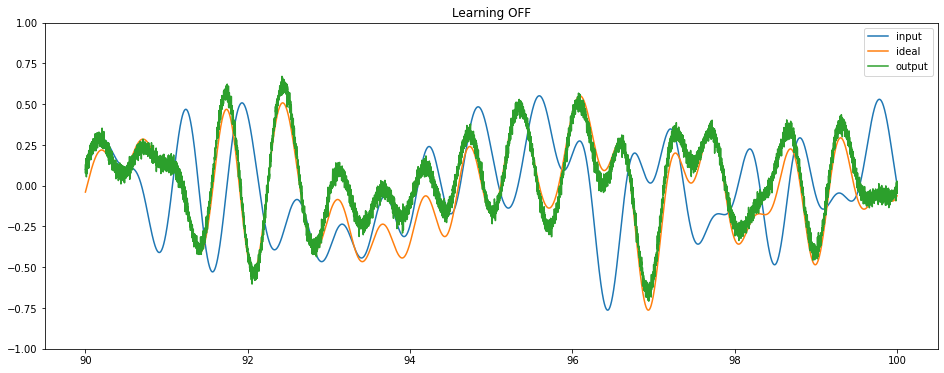

In [7]:
with nengo.Simulator(net) as sim:
    sim.run(sim_t)

# we'll break up the output into multiple plots, just for 
# display purposes
t_per_plot = 10
for i in range(sim_t // t_per_plot):
    plot_slice = (sim.trange() >= t_per_plot * i) & (
        sim.trange() < t_per_plot * (i + 1)
    )

    plt.figure(figsize=(16, 6))
    plt.plot(sim.trange()[plot_slice], sim.data[p_stim][plot_slice], label="input")
    plt.plot(sim.trange()[plot_slice], sim.data[p_ideal][plot_slice], label="ideal")
    plt.plot(sim.trange()[plot_slice], sim.data[p_out][plot_slice], label="output")
    if i * t_per_plot < sim_t * 0.8:
        plt.title("Learning ON")
    else:
        plt.title("Learning OFF")
    plt.ylim([-1, 1])
    plt.legend();

We can see that the network is successfully learning to compute a delay.
We could use these same principles to train a network
to compute any time-varying function of some input signal,
and an LMU will always provide
an optimal representation of that input signal.

See these other examples for some other applications of LMUs:

- [State of the art performance on the psMNIST task using LMUs in NengoDL](
https://www.nengo.ai/nengo-dl/examples/lmu.html)
<!-- - TODO: loihi example -->

As well as [the original paper][paper] for more information on LMUs.

[paper]: https://papers.nips.cc/paper/9689-legendre-memory-units-continuous-time-representation-in-recurrent-neural-networks.pdf